# Part 1: Data Processing

### Cleaning

In [1]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import pandas as pd
from tabulate import tabulate

#compile regular expressions
num_pattern = re.compile(r"(\d+)")
date_pattern = re.compile(r'\b\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}\b')
email_pattern = re.compile(r'\b[a-zA-Z0-9._-]+@[a-zA-Z0-9.-]+\.[a-z|A-Z]{2,}\b')
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def clean_text(text: str):
    """cleans raw data"""
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(date_pattern, "<DATE>", text)
    text = re.sub(email_pattern, "<EMAIL>", text)
    text = re.sub(url_pattern, "<URL>", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(num_pattern, "<NUM>", text)
    return text

#compile stopwords and initialize stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def remove_stopwords(text: str):
    """remove stopwords from string"""
    return ' '.join([word for word in text.split() if word not in stop_words])

def stemming_data(text: str):
    """returns stemmed data where stopwords are removed from string"""
    return ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

def word_stemming_stopwords(df):
    """print reduction rate of vocabulary of tokenized data"""
    avg_unique_words = df.str.split().apply(set).apply(len).mean()

    df = df.apply(stemming_data) #stemming
    avg_stemmed_words = df.str.split().apply(set).apply(len).mean()
    
    df = df.apply(remove_stopwords) #removing stopwords
    avg_stopwords_removed = df.str.split().apply(set).apply(len).mean()
    
    print(tabulate([
        ["Stemming", 100 * (avg_unique_words - avg_stemmed_words) / avg_unique_words],
        ["Removing Stopwords", 100 * (avg_unique_words - avg_stopwords_removed) / avg_unique_words]
    ], headers=["Data Cleaning Type", "Reduction Rate of Vocabulary (%)"], tablefmt='orgtbl'))
    return df

Importing data

In [1]:
#raw_data_fake_news = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv")
raw_data_fake_news = pd.read_csv("C:\\Users\\Maher\\Documents\\news_data.csv", low_memory=False)

NameError: name 'pd' is not defined

Cleaning and doing vocabulary analasis

In [ ]:
#keeping only the relevant collumns
data_fake_news = raw_data_fake_news.copy()[
    ['domain', 'type', 'content', 'title', 'authors', 'meta_description', 'meta_keywords']].head(1000)

In [ ]:
#cleaning raw text using clean_text function on all elements
data_fake_news['content'] = data_fake_news['content'].apply(clean_text)

In [ ]:
#stemming and removing stopwords, while calculating the reduction in vocabulary
data_fake_news['content'] = word_stemming_stopwords(data_fake_news['content'])

| Data Cleaning Type   |   Reduction Rate of Vocabulary (%) |
|----------------------+------------------------------------|
| Stemming             |                            24.7061 |
| Removing Stopwords   |                            25.0311 |


### Observations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_table(df: pd.DataFrame):
    """Creating a table over the distribution of types of articles"""
    type_counts = df['type'].value_counts()
    type_order = type_counts.index
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='type', order=type_order, color='fuchsia')
    plt.title("Distribution of Article Types")
    plt.xlabel("Article Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.show()

def article_distribution_of_missing_values(dataframe: pd.DataFrame, column: str):
    """Counts missing values in a given column of the pandas dataframe, 
    and plots the distribution of count/article type."""
    dataframe = dataframe[dataframe[column].isna()]

    type_count = dataframe['type'].value_counts()

    type_order = type_count.index

    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataframe, x='type', order=type_order, color='fuchsia')

    plt.title("Distribution of article types for articles without any author")
    plt.xlabel("Article Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    plt.show()

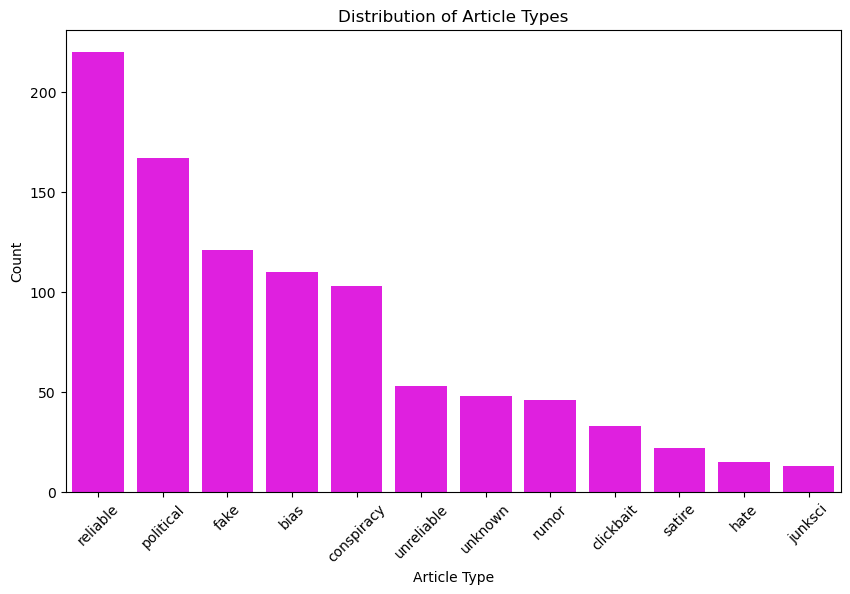

In [ ]:
create_table(data_fake_news)

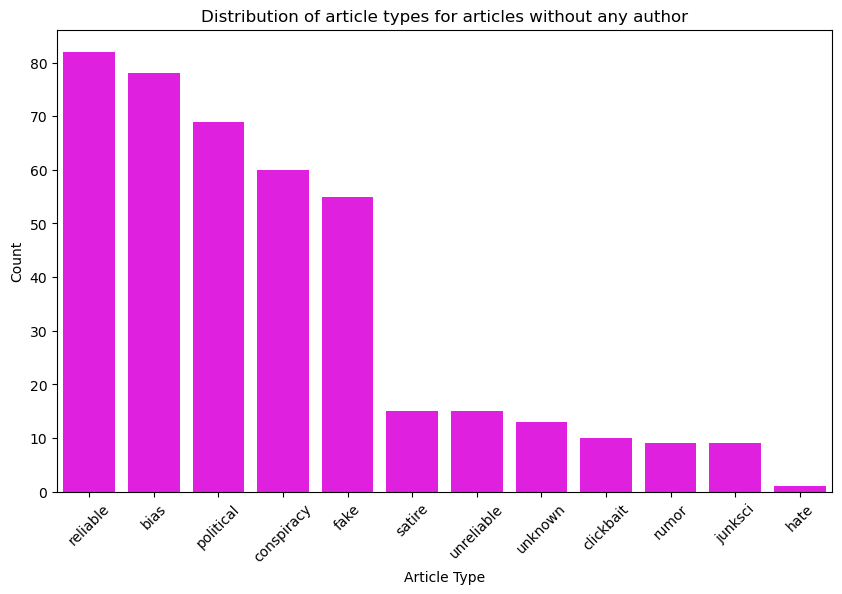

In [ ]:
article_distribution_of_missing_values(data_fake_news, 'authors')

# Part 2: Simple Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def create_logistic_model(X, y):
    """Create a logistic model and return accuracy"""
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, stratify=y, random_state=0)
    model_logistic = LogisticRegression()
    model_logistic.fit(X_train, y_train)  # Train logistic model
    return accuracy_score(y_val, model_logistic.predict(X_val))  # Test accuracy

def df_type_binary(df):
    """Return the dataframe where the types grouped into reliable or fake"""
    reliable_type = {"reliable", "political", "clickbait"}
    df["type"] = df["type"].apply(lambda x: x in reliable_type)
    return df[~df["type"].isin(['fake', 'satire', 'bias', 'conspiracy', 'junksci'])]

def transform_str(X: str):
    """Transform X string-data using OneHotEncoder"""
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    return one_hot_encoder.fit_transform(X.values.reshape(-1, 1))

def vocabulary_set(X: str):
    """Return a space-separated string of unique words"""
    return " ".join({word for word in set(X.split())})

def vocabulary_complexity(X: str):
    """Calculate the vocabulary complexity"""
    words = X.split()
    return len(set(words)) / len(words)


In [ ]:
#prepareing y data
binary_fake_news = df_type_binary(data_fake_news.copy())
y = binary_fake_news['type']

#prepareing X data
X_domain = transform_str(binary_fake_news['domain'])
X_content = transform_str(binary_fake_news['content'])
X_title = transform_str(binary_fake_news['title'])
X_vocab_count = transform_str(binary_fake_news['content'].apply(vocabulary_set))
X_vocab_percent = np.array(binary_fake_news['content'].apply(vocabulary_complexity)).reshape(-1, 1)
X_meta_desc = transform_str(binary_fake_news['meta_description'])
X_meta_key = transform_str(binary_fake_news['meta_keywords'])

#random guessing from porportion of reliable to fake data
random_acc = binary_fake_news['type'].value_counts()[0] / (binary_fake_news['type'].value_counts()[0] + 
                                                           binary_fake_news['type'].value_counts()[1])

#creating logistic models for different types of X data
print(tabulate([
    ["randomly quessing", random_acc],
    ["domain", create_logistic_model(X_domain, y)], 
    ["content", create_logistic_model(X_content, y)],
    ["title", create_logistic_model(X_title, y)],
    ["number of unique words", create_logistic_model(X_vocab_count, y)],
    ["percentage of unique words", create_logistic_model(X_vocab_percent, y)],
    ["meta description", create_logistic_model(X_meta_desc, y)],
    ["meta keywords", create_logistic_model(X_meta_key, y)]
    ], headers=["X data", "Accuracy"], tablefmt='orgtbl'))

| X data                     |   Accuracy |
|----------------------------+------------|
| randomly quessing          |       0.58 |
| domain                     |       0.92 |
| content                    |       0.63 |
| title                      |       0.62 |
| number of unique words     |       0.63 |
| percentage of unique words |       0.58 |
| meta description           |       0.58 |
| meta keywords              |       0.74 |


/var/folders/j9/2m00cy3j63d_4fdvcf9png8h0000gn/T/ipykernel_96498/2338110695.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random_acc = binary_fake_news['type'].value_counts()[0] / (binary_fake_news['type'].value_counts()[0] +
/var/folders/j9/2m00cy3j63d_4fdvcf9png8h0000gn/T/ipykernel_96498/2338110695.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  binary_fake_news['type'].value_counts()[1])


describe what importan parameters to use in function


BBC with or without

# Part 3: Advanced Model

# Part 4: Evaluation

# Part 5: Conclusions